# PIK3CA trans phospho site anaylsis 

This notebook performs t-tests of phosphorylation abundance between PIK3CA hotspot mutations (E542K,E545K,and H1047R)and wildtype tumors (no PIK3CA mutation of any kind) for a set of interacting genes. The first gene set is from wikipathway's interacting genes for PIK3CA. The second set is genes are closer to PIK3CA in the EGFR pathway. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import sys 
import re
import cptac
import statsmodels.stats.multitest
import operator
import cptac.utils as u
import warnings
warnings.filterwarnings('ignore')

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
cptac warning: Your version of cptac (0.8.2) is out-of-date. Latest is 0.8.4. Please run 'pip install --upgrade cptac' to update it. (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 8)


Load CPTAC data

In [2]:
br = cptac.Brca()
endo = cptac.Endometrial()
col = cptac.Colon()

In [3]:
def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

# Get Pik3ca pathway proteins

In [21]:

prot = u.get_proteins_in_pathways('PI3K-Akt Signaling Pathway', 'wikipathways')
prot_list = list(prot.member)

phos_list = ["PIK3CA_Location","PIK3CA_Mutation"]
for gene in prot_list:
    phos = gene + "_phosphoproteomics"
    phos_list.append(phos)


# Run Wrap T-test on phosphosites in PIK3CA pathway

In [22]:
def get_trans_results(cancer, phos_list , return_result_df = True):
    phos = cancer.join_omics_to_mutations(omics_df_name = "phosphoproteomics",mutations_genes="PIK3CA", tissue_type="tumor")
    if cancer == br:
        phos = u.reduce_multiindex(df=phos, levels_to_drop=["Database_ID","Peptide"])
    if cancer == col:
        phos = u.reduce_multiindex(df=phos, levels_to_drop=["Database_ID"])

    genefilter = phos.columns.get_level_values("Name").isin(phos_list)
    phos_pik3ca = phos[phos.columns[genefilter]]
    phos_pik3ca = cptac.utils.reduce_multiindex(phos_pik3ca, flatten=True)
    
    
    phos_pik3ca['PIK3CA_Mutation'] = [','.join(map(str, l)) for l in phos_pik3ca['PIK3CA_Mutation']]
    phos_pik3ca['PIK3CA_Location'] = [','.join(map(str, l)) for l in phos_pik3ca['PIK3CA_Location']]
    phos_pik3ca  = rename_duplicate_cols(phos_pik3ca)
    hotspot = phos_pik3ca[(phos_pik3ca.PIK3CA_Location.str.contains('E542K'))| 
                    phos_pik3ca.PIK3CA_Location.str.contains('E545K')| 
                    phos_pik3ca.PIK3CA_Location.str.contains('H1047R')]
    hotspot["PIK3CA_Mutation"] = "Hotspot"
    wt = phos_pik3ca[(phos_pik3ca.PIK3CA_Mutation.str.contains('Wildtype'))]
    hotspot_wt = pd.concat([hotspot, wt])
    if return_result_df:

        cols = hotspot_wt.columns.to_list()
        cols.remove("PIK3CA_Mutation")
        cols.remove("PIK3CA_Location")
        print("n sites = " + str(len(cols)))
        phos_pval = u.wrap_ttest(hotspot_wt, 'PIK3CA_Mutation', cols,return_all=True, pval_return_corrected= True, correction_method= "FDR_bh")
        return phos_pval
    else:
        return hotspot_wt
    

# Brca

In [23]:
brca_results = get_trans_results(br,phos_list)

brca_results.head(20)

n sites = 636


,Comparison,P_Value
0,AKT2_phosphoproteomics_S34,0.048497
1,FOXO3_phosphoproteomics_T32,0.075094
2,MAP2K2_phosphoproteomics_S306,0.175429
3,GSK3B_phosphoproteomics_S9,0.175429
4,FOXO3_phosphoproteomics_S253,0.175429
5,FOXO3_phosphoproteomics_S311,0.175429
6,TSC2_phosphoproteomics_S939,0.241697
7,CSF1R_phosphoproteomics_S716,0.243040
8,IRS1_phosphoproteomics_S330,0.246305
9,IRS1_phosphoproteomics_S270,0.354867


In [25]:
#brca_results[brca_results["Comparison"].str.contains('AKT')]

# Endo

In [24]:
Endo_results = get_trans_results(endo,phos_list)
Endo_results.head(20)

n sites = 1281


,Comparison,P_Value
0,AKT1_phosphoproteomics_S124,0.997742
1,PKN2_phosphoproteomics_T124,0.997742
2,PKN2_phosphoproteomics_T364,0.997742
3,PKN2_phosphoproteomics_T533,0.997742
4,PKN2_phosphoproteomics_T628,0.997742
5,PKN2_phosphoproteomics_T816,0.997742
6,PKN2_phosphoproteomics_T958,0.997742
7,PKN2_phosphoproteomics_Y624,0.997742
8,PKN3_phosphoproteomics_S488,0.997742
9,PKN2_phosphoproteomics_T121,0.997742


# Colon 

In [11]:
Colon_results = get_trans_results(col,phos_list)
print("n sites = " + str(len(Colon_results)))
Colon_results.head(10)


n sites = 620
n sites = 260


,Comparison,P_Value
0,TSC2_phosphoproteomics_S1420,0.000981
1,EGFR_phosphoproteomics_Y1092,0.004633
2,NFKB1_phosphoproteomics_S937,0.010017
3,SPP1_phosphoproteomics_S254,0.020474
4,IRS1_phosphoproteomics_S629,0.026113
5,IRS1_phosphoproteomics_S636,0.028448
6,SPP1_phosphoproteomics_S263,0.029418
7,EIF4B_phosphoproteomics_S504,0.030408
8,PDGFRB_phosphoproteomics_S705,0.034606
9,TSC2_phosphoproteomics_S1452,0.035101


# Make PIK3CA Figure 2B

Get dataframe of phosphoproteomic and PIK3CA mutation status

In [ ]:
Colon_trans_df =  get_trans_results(col,phos_list,return_result_df=False)
Brca_trans_df =  get_trans_results(br,phos_list,return_result_df=False)
Endo_trans_df =  get_trans_results(endo,phos_list,return_result_df=False)

Make dataframe with columns that we want in the figure

In [26]:

def formatdf(df,cancer):
    newdf = df[["PIK3CA_Mutation","AKT2_phosphoproteomics_S34"]]
    newdf = newdf.rename(columns={"AKT2_phosphoproteomics_S34": "Phospho"})
    newdf = newdf.assign(cancer_site = cancer + "_AKT2_S34")
    
    subset = df[["PIK3CA_Mutation","FOXO3_phosphoproteomics_S253"]]
    subset = subset.rename(columns={"FOXO3_phosphoproteomics_S253": "Phospho"})
    subset = subset.assign(cancer_site = cancer + "_FOXO3_S253")
    newdf = newdf.append(subset)
    
    
    if cancer == "Colon":
        subset= df[["PIK3CA_Mutation","GSK3B_phosphoproteomics_S9"]]
        subset = subset.rename(columns={"GSK3B_phosphoproteomics_S9": "Phospho"})
        subset = subset.assign(cancer_site = cancer + "_GSK3B_S9")
        newdf = newdf.append(subset)
        return newdf
    else:
        subset = df[["PIK3CA_Mutation","FOXO3_phosphoproteomics_T32"]]
        subset = subset.rename(columns={"FOXO3_phosphoproteomics_T32": "Phospho"})
        subset = subset.assign(cancer_site = cancer + "_FOXO3_T32")
        newdf = newdf.append(subset)
        
        subset= df[["PIK3CA_Mutation","GSK3B_phosphoproteomics_S9"]]
        subset = subset.rename(columns={"GSK3B_phosphoproteomics_S9": "Phospho"})
        subset = subset.assign(cancer_site = cancer + "_GSK3B_S9")
        newdf = newdf.append(subset)
    return newdf



In [27]:
#Run function for each cancer and then append to make one df
B1 = formatdf(Brca_trans_df,"BRCA")
E1 = formatdf(Endo_trans_df,"Endo")
C1 = formatdf(Colon_trans_df,"Colon")
plot_df = B1.append(E1)
plot_df = plot_df.append(C1)
plot_df

Name,PIK3CA_Mutation,Phospho,cancer_site
Patient_ID,,,
CPT001846,Hotspot,0.6594,BRCA_AKT2_S34
X06BR014,Hotspot,2.7671,BRCA_AKT2_S34
X11BR004,Hotspot,0.0557,BRCA_AKT2_S34
X11BR013,Hotspot,-1.0771,BRCA_AKT2_S34
X11BR014,Hotspot,1.9034,BRCA_AKT2_S34
...,...,...,...
21CO006,Wildtype_Tumor,NaN,Colon_GSK3B_S9
21CO007,Wildtype_Tumor,-0.2040,Colon_GSK3B_S9
22CO004,Wildtype_Tumor,-0.2310,Colon_GSK3B_S9


Make list of the order for X axis labels 

In [14]:
x_order = ['BRCA_AKT2_S34','Endo_AKT2_S34','Colon_AKT2_S34','BRCA_GSK3B_S9','Endo_GSK3B_S9','Colon_GSK3B_S9','BRCA_FOXO3_S253','Endo_FOXO3_S253','Colon_FOXO3_S253','BRCA_FOXO3_T32','Endo_FOXO3_T32']


In [16]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

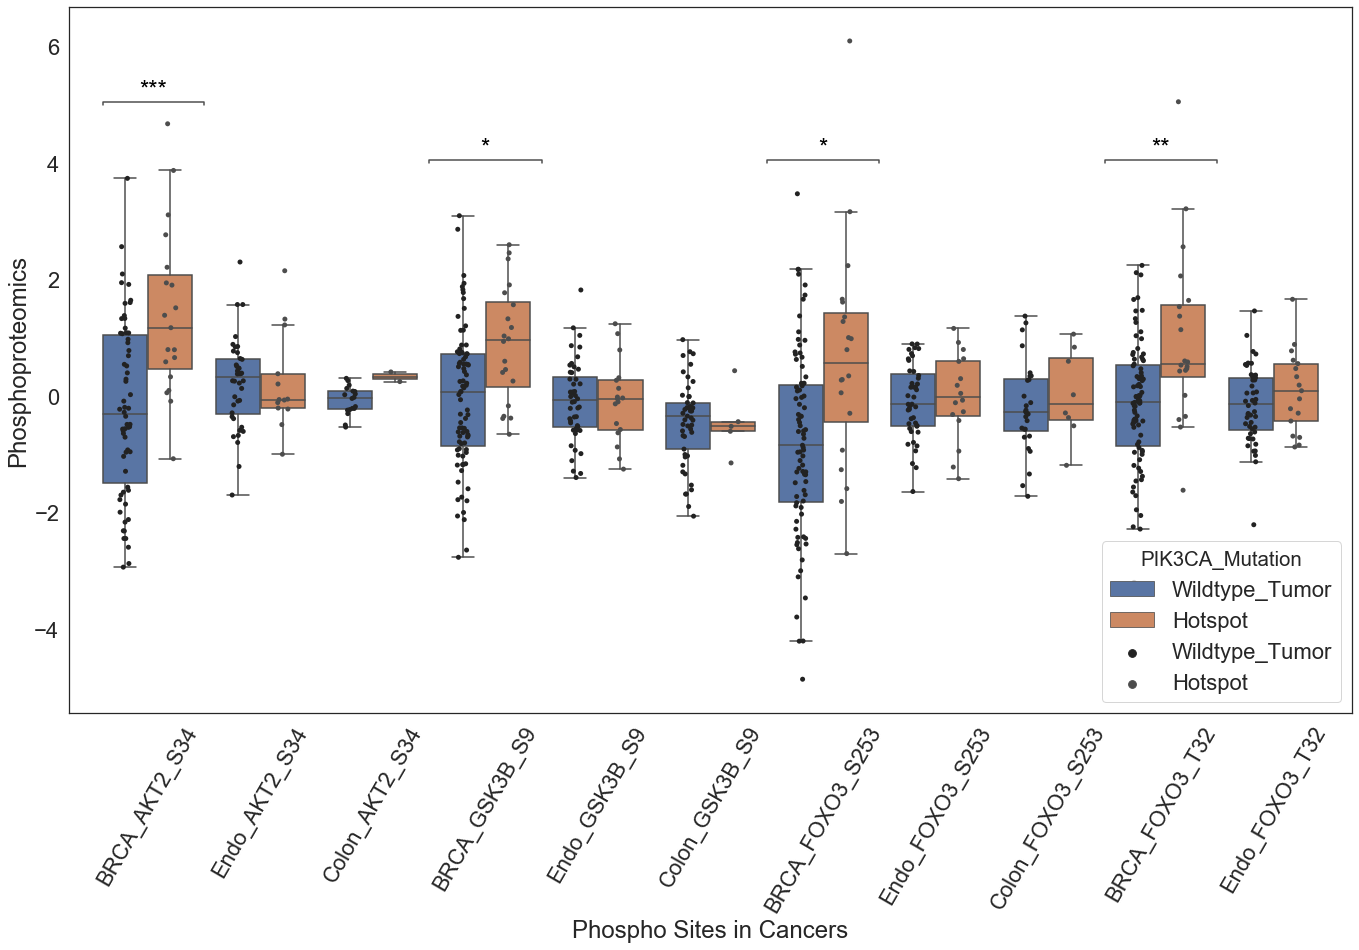

In [17]:
# cis plot
gene = 'PIK3CA'
plt.rcParams['figure.figsize']=(23, 13) #size of plot


sns.set(font_scale = 2, style = "white")
boxplot = sns.boxplot(x='cancer_site', y= "Phospho", data = plot_df, hue = 'PIK3CA_Mutation'
                      ,hue_order = ["Wildtype_Tumor", "Hotspot"], order = x_order,  showfliers = False)   
#boxplot.set_title('Pancancer cis effect of PIK3CA Missense')
boxplot = sns.stripplot(x='cancer_site', y= "Phospho", data = plot_df, jitter = True, 
                           color = ".3", hue = 'PIK3CA_Mutation', hue_order = ["Wildtype_Tumor", "Hotspot"], order = x_order, dodge = True)
boxplot.set(xlabel = "Phospho Sites in Cancers", ylabel = 'Phosphoproteomics')
boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=60)


format_pval_annotation('***', -.4, .5, 5) 
format_pval_annotation('**', 8.5, 9.5, 4) 
format_pval_annotation('*', 5.5, 6.5, 4) 
format_pval_annotation('*', 2.5, 3.5, 4) 
plt.show()
plt.clf()
plt.close()

In [18]:

fig = boxplot.get_figure()
fig.savefig("PIK3CA_Figure2B.png", dpi = 300,bbox_inches="tight")